In [1]:
import sys
sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Release')
sys.path.insert(0, 'D:/pascucci/ppt/2022/6_NASA/idx2/build/Source/Python/RelWithDebInfo')
#sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Debug')
import os
import idx2Py as i2p
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import *
import concurrent.futures

path_prefix = 'J:/nasa/'
if not os.path.exists (path_prefix): 
  path_prefix = "W:/cedmav/hello/"

%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

vmin = -1
vmax = 1

C:\Users\Duong\AppData\Local\Temp\ipykernel_23948\1727455562.py:19: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Set up color map

In [2]:
import colorsys

Points = [
  -10,
  -2.18552,
  -0.260014,
  0.00702716,
  0.372452,
  0.709768,
  10  
]

RGBPoints = [  
  [0.27843137254900002, 0.27843137254900002, 0.85882352941200002],
  [0.0, 0.33333333333333331, 1.0],
  [0.33333333333333331, 0.66666666666666663, 1.0],
  [0.0, 0.0, 0.49803921568627452],  
  [0.82745098039215681, 1.0, 0.73333333333333328],
  [1.0, 0.66666666666666663, 0.0],
  [0.87843137254899994, 0.30196078431399997, 0.30196078431399997]
]

def get_continuous_cmap(rgb_list, float_list=None):
  if float_list:
    # normalize the float list
    min_val = min(float_list)
    max_val = max(float_list)
    my_range = max_val - min_val
    float_list = [(v - min_val)/my_range for v in float_list]
    #print(float_list)
  else:
    float_list = list(np.linspace(0, 1, len(rgb_list)))

  cdict = dict()  
  for num, col in enumerate(['red', 'green', 'blue']):
    col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(0, len(float_list))]
    cdict[col] = col_list
  cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
  return cmp

my_cmap = get_continuous_cmap(RGBPoints, Points)

# Some helper functions

In [3]:
def get_file_name(input_dir, dataset, field, time):
  return input_dir + '/' + dataset + '/' + field + '-time-' + repr(time) + '.idx2' 

def get_extent(dataset, face):
  if dataset == 'llc4320':
    return (0, 0, 0, 4320 * 4, 4320 * 3, 90)
  return (0, 0, 0, 2160 * 4, 2160 * 3, 90)

# Query 
# extent should be a 4-tuple: (from_x, from_y, from_depth, dim_x, dim_y, dim_depth)
def query_data(input_dir, dataset, field, time, downsampling, accuracy, extent=None):  
  # split the extent into 4 pieces
  if extent == None:
    extent = get_extent(dataset, face)
  e0 = extent
  x = e0[0]
  y = e0[1]
  d = e0[2]
  dx = e0[3]
  dy = e0[4]
  dd = e0[5]
  dx0 = dx//2
  dx1 = dx-dx0
  dy0 = dy//2
  dy1 = dy-dy0
  e1 = (x    , y    , d, dx0, dy0, dd)
  e2 = (x+dx0, y    , d, dx1, dy0, dd)
  e3 = (x    , y+dy0, d, dx0, dy1, dd)
  e4 = (x+dx0, y+dy0, d, dx1, dy1, dd)

  file = get_file_name(input_dir, dataset, field, time)
    
  array = None
  if dx < 16 or dy < 16: # if too small, don't spawn threads
    array = i2p.DecodeExtent3f32(file, input_dir, extent, downsampling, accuracy)
  else:
    with concurrent.futures.ThreadPoolExecutor() as executor:
      f1 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e1, downsampling, accuracy)    
      f2 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e2, downsampling, accuracy)
      f3 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e3, downsampling, accuracy)
      f4 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e4, downsampling, accuracy)
      a1 = f1.result()
      a2 = f2.result()
      a3 = f3.result()
      a4 = f4.result()
      shape = (a1.shape[0], a1.shape[1] + a4.shape[1], a1.shape[2] + a4.shape[2])
      array = np.empty(shape, dtype=float)

      array[:, :a1.shape[1], :a1.shape[2]] = a1
      array[:, :a2.shape[1], a1.shape[2]:] = a2
      array[:, a1.shape[1]:, :a3.shape[2]] = a3
      array[:, a1.shape[1]:, a3.shape[2]:] = a4
  
  return array

# Vertical slicing along Y (constant X)

<IPython.core.display.Javascript object>


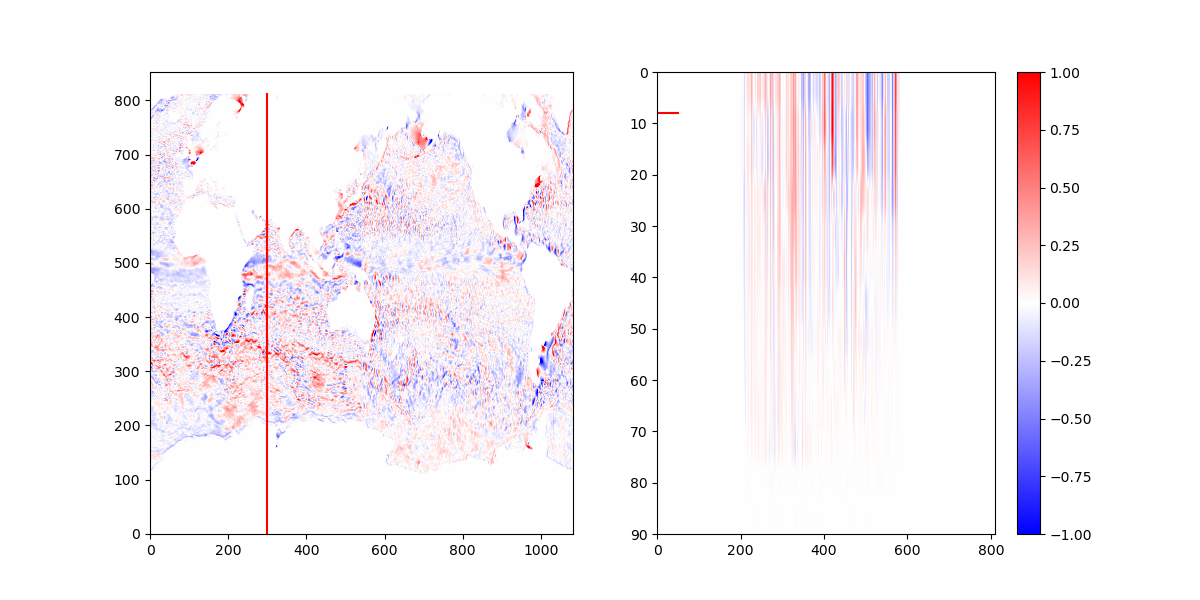

C:\Users\Duong\AppData\Local\Temp\ipykernel_23948\1144051821.py:30: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(plot)


interactive(children=(IntSlider(value=0, description='t', layout=Layout(width='400px'), max=10), Output()), _d…

interactive(children=(IntSlider(value=0, description='d', layout=Layout(width='500px'), max=89), Output()), _d…

interactive(children=(IntSlider(value=300, description='x', layout=Layout(width='1000px'), max=1081, step=4), …

In [16]:
input_dir = path_prefix
dataset = 'llc2160_x_y_depth_bpt_64'
field = 'u'
n = 2160
ndepths = 90
face = 0
depth = 40
time = 0
accuracy = 0.1
accuracy2 = 1
downsampling = [3, 3, 3]
downsampling2 = [2, 2, 0]
array = np.empty((1,1,1), float)
array2 = np.empty((1, 1,1), float)

xbegin = 300

array = query_data(input_dir, dataset, field, time, downsampling, accuracy)

d = (array.shape[2], array.shape[1])
D = (n * 4, n * 3)
s = (D[0] / d[0], D[1] / d[1])
#print(array.shape)

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, (ax, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plot = ax.imshow(array[0, :, :], origin = 'lower', cmap = 'bwr', aspect = 'auto', vmin = vmin, vmax = vmax)
plt.colorbar(plot)

def query_slice(x):
  global array2
  x = int(x * s[0])
  extent = (x, 0, 0, 1, n * 3, ndepths)
  file_name = get_file_name(input_dir, dataset, 'u', time)
  array2 = i2p.DecodeExtent3f32(file_name, input_dir, extent, downsampling, accuracy)[:,:,0]  
  
query_slice(xbegin)
plot2 = ax2.imshow(array2[:, :], origin = 'upper', cmap = 'bwr', aspect = 'auto', vmin = vmin, vmax = vmax, extent=(0, array2.shape[1], 90, 0))
#ax2.set_xticks(range(0, 90))
#ax2.set_yscale(4)
line1 = None
line2 = None
pause = True

def onClick(event):
  global pause
  pause ^= True
  
fig.canvas.mpl_connect('button_press_event', onClick)

def change_time(t): # get time step t   
    global time, array
    time = t
    array = query_data(input_dir, dataset, field, time, downsampling, accuracy, (0,0,depth,n*4,n*3,1))
    plot.set_data(array[0, :, :])
    move_x(xbegin)

def draw_line():
  global line1
  if line1 is not None:
    line1.pop(0).remove()
  line1 = ax.plot([xbegin, xbegin], [0,array.shape[1]], color = 'r')
  
def draw_line2():
  global line2
  if line2 is not None:
    line2.pop(0).remove()
  line2 = ax2.plot([0, 50], [depth,depth], color = 'r')
  
def query_slice(x):
  global array2
  x = int(x * s[0])
  extent = (x, 0, 0, 1, n * 3, ndepths)
  file_name = get_file_name(input_dir, dataset, 'u', time)
  array2 = i2p.DecodeExtent3f32(file_name, input_dir, extent, downsampling, accuracy)[:,:,0]  

def move_x(x): # we should query a region and cache
  global xbegin
  xbegin = x
  query_slice(x)
  draw_line()
  plot2.set_data(array2[:,:])
  
def to_face(f):
  if f >= 2:
    return f + 1
  return f

def change_depth(d):
  global depth
  depth = d
  array = query_data(input_dir, dataset, field, time, downsampling, accuracy, (0,0,depth,n*4,n*3,1))
  plot.set_data(array[0, :, :])
  draw_line2()

def animate(t):
  global pause
  if pause:
    return
  #global first_draw, array, array2, time_block
  plot2.set_data(array2[t//pow(2,downsampling[2]), :,:])
  return [plot2]

#interact(change_time, t = widgets.IntSlider(min = 0, max = 10, step = 1, value = 0, layout = Layout(width = '400px')));
interact(change_time, t = widgets.IntSlider(min = 0, max = 10, step = 1, value = 0, layout = Layout(width = '400px')));
interact(change_depth, d = widgets.IntSlider(min=0, max=89, step=1, value=0, layout=Layout(width='500px')));
# anim = FuncAnimation(fig2, animate, frames=times_per_brick, interval=100, blit=True, repeat=True)
interact(move_x, x = widgets.IntSlider(min = 0, max = (n*4-1)/s[0], step = 4, value = xbegin, layout = Layout(width = '1000px')));
# interact(f, t = widgets.IntSlider(min = 0, max = 15, step = 1, value = 0, layout = Layout(width = '500px')));